#Import all required libraries

In [8]:
!pip install split-folders
!pip install pydub
!pip install pesq
!pip install pystoi
!pip install git+https://github.com/aliutkus/speechmetrics#egg=speechmetrics[cpu]

  Created wheel for pesq: filename=pesq-0.0.3-cp37-cp37m-linux_x86_64.whl size=210448 sha256=04aa9400206cef2c9412acdb5c74337974db854354217c66d732049ecf55b79b
  Stored in directory: /root/.cache/pip/wheels/4f/67/5b/aa7cf31fe0c7199e35c604bb7bc91c629a13726bf221fedba0
Successfully built pesq
  Created wheel for pystoi: filename=pystoi-0.3.3-py2.py3-none-any.whl size=7793 sha256=ae4e9d40da9176c1a1478aa1e65a121f3abdfafac3b41bfbeebdaf88dda491f6
  Stored in directory: /root/.cache/pip/wheels/46/4a/ad/3ab460193ed0535430b4b1575f255aa6bae69df17453628e86
Successfully built pystoi
  Cloning https://github.com/aliutkus/speechmetrics to /tmp/pip-install-df3444io/speechmetrics_da38115b7ca8497d9cec9001bed85fc2
  Running command git clone -q https://github.com/aliutkus/speechmetrics /tmp/pip-install-df3444io/speechmetrics_da38115b7ca8497d9cec9001bed85fc2
  Cloning https://github.com/vBaiCai/python-pesq to /tmp/pip-install-df3444io/pypesq_beae3ba1b9294692b4ac652503ca88c1
  Running command git clone -q ht

In [9]:
############################################################ import libraries
import numpy as np
# Packages we're using
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
from tqdm import tqdm
import numpy as np
import math
from PIL import Image
import time
from pydub import AudioSegment
from pydub.playback import play
import glob
import os
from keras.callbacks import EarlyStopping
import tensorflow as tf
import splitfolders
import shutil
import random
# importing necessary libraries
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import Flatten,concatenate,UpSampling2D,ZeroPadding2D,Cropping2D
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.metrics import TopKCategoricalAccuracy
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM,Embedding,Rescaling,TimeDistributed,BatchNormalization,LeakyReLU
from keras.callbacks import ModelCheckpoint
import wave
from pesq import pesq
import IPython.display as ipd
import librosa
import librosa.display
from ipykernel import kernelapp as app
import soundfile as sf
from pystoi import stoi
import speechmetrics
import sys

import numpy as np
# Packages we're using
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
from tqdm import tqdm
import numpy as np
import math
from PIL import Image
import time
from pydub import AudioSegment
from pydub.playback import play
import glob
import os
import tensorflow as tf
import splitfolders
import shutil
import keras
# importing necessary libraries
import tensorflow as tf
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Input
from keras.layers import Flatten,concatenate,UpSampling2D,ZeroPadding2D,Cropping2D, Activation
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD,Adam
from keras.layers.convolutional import Conv2D, Conv2DTranspose, Conv1D, Conv1DTranspose
#from SpectralNormalizationKeras import DenseSN, ConvSN1D, ConvSN2D, ConvSN3D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.metrics import TopKCategoricalAccuracy
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM,Embedding,Rescaling,TimeDistributed,BatchNormalization
from keras.callbacks import ModelCheckpoint
import wave

# Obtain data from Kaggle and from our generated dataset

In [10]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [11]:
################################################################## Libri dataset
!kaggle datasets download -d earth16/libri-speech-noise-dataset

100% 6.01G/6.03G [00:58<00:00, 65.1MB/s]
100% 6.03G/6.03G [00:58<00:00, 111MB/s] 


In [ ]:
################################################################# Unzip Libri dataset
!unzip /content/libri-speech-noise-dataset.zip

In [ ]:
################################################################### Unzip generated clean dataset
!unzip /content/drive/MyDrive/Clean_arr.zip -d /content/clean_data

In [ ]:
################################################################# Unzip generated noisy dataset
!unzip /content/drive/MyDrive/Noisy_arr.zip -d /content/noisy_data

# Listening to clean and noisy samples

In [3]:
################################################################# Functions to obtain signal from spectogram
FFT_LENGTH = 512
WINDOW_LENGTH = 512
WINDOW_STEP = int(WINDOW_LENGTH / 2)
magnitudeMin = float("inf")
magnitudeMax = float("-inf")
phaseMin = float("inf")
phaseMax = float("-inf")

phaseMax = 3.141592653589793 
phaseMin = -3.141592653589793
magnitudeMax = 2211683.973249525
magnitudeMin = 0.0

rate = 16000

def amplifyMagnitudeByLog(d):
    return 188.301 * math.log10(d + 1)

def weakenAmplifiedMagnitude(d):
    return math.pow(10, d/188.301)-1

def generateLinearScale(magnitudePixels, phasePixels, 
                        magnitudeMin, magnitudeMax, phaseMin, phaseMax):
    height = magnitudePixels.shape[0]
    width = magnitudePixels.shape[1]
    magnitudeRange = magnitudeMax - magnitudeMin
    phaseRange = phaseMax - phaseMin
    rgbArray = np.zeros((height, width, 3), 'uint8')
    
    for w in range(width):
        for h in range(height):
            magnitudePixels[h,w] = (magnitudePixels[h,w] - magnitudeMin) / (magnitudeRange) * 255 * 2
            magnitudePixels[h,w] = amplifyMagnitudeByLog(magnitudePixels[h,w])
            phasePixels[h,w] = (phasePixels[h,w] - phaseMin) / (phaseRange) * 255
            red = 255 if magnitudePixels[h,w] > 255 else magnitudePixels[h,w]
            green = (magnitudePixels[h,w] - 255) if magnitudePixels[h,w] > 255 else 0
            blue = phasePixels[h,w]
            rgbArray[h,w,0] = int(red)
            rgbArray[h,w,1] = int(green)
            rgbArray[h,w,2] = int(blue)
    return rgbArray

def recoverLinearScale(rgbArray, magnitudeMin, magnitudeMax, 
                       phaseMin, phaseMax):
    width = rgbArray.shape[1]
    height = rgbArray.shape[0]
   # print(phaseMax,phaseMin)
    magnitudeVals = rgbArray[:,:,0].astype(float) + rgbArray[:,:,1].astype(float)
    phaseVals = rgbArray[:,:,2].astype(float)
    phaseRange = phaseMax - phaseMin
    magnitudeRange = magnitudeMax - magnitudeMin
     
    for w in range(width):
        for h in range(height):
            phaseVals[h,w] = (phaseVals[h,w] / 255 * phaseRange) + phaseMin
            magnitudeVals[h,w] = weakenAmplifiedMagnitude(magnitudeVals[h,w])
            magnitudeVals[h,w] = (magnitudeVals[h,w] / (255*2) * magnitudeRange) + magnitudeMin
    return magnitudeVals, phaseVals

def recoverSignalFromSpectrogram(numpyarray):
    data = np.array( numpyarray, dtype='uint8' )
    width = data.shape[1]
    height = data.shape[0]

    magnitudeVals, phaseVals \
    = recoverLinearScale(data, magnitudeMin, magnitudeMax, phaseMin, phaseMax)
        
    recovered = np.zeros(WINDOW_LENGTH * width // 2 + WINDOW_STEP, dtype=np.int16)
    recovered = np.array(recovered,dtype=np.int16)
    
    for w in range(width):
        toInverse = np.zeros(height, dtype=np.complex_)
        for h in range(height):
            magnitude = magnitudeVals[height-h-1,w]
            phase = phaseVals[height-h-1,w]
            toInverse[h] = magnitude * math.cos(phase) + (1j * magnitude * math.sin(phase))
        signal = np.fft.irfft(toInverse)
        recovered[w*WINDOW_STEP:w*WINDOW_STEP + WINDOW_LENGTH] += signal[:WINDOW_LENGTH].astype(np.int16)
    return recovered

In [12]:
############################################################## listening to noisy sound file
filename = '/content/noisy_data/content/Noisy_arr/88572e40-45db-11e9-81ce-69b74fd7e64e.npy'
new_num_arr = np.load(filename)
new_num_arr.shape
data = recoverSignalFromSpectrogram(new_num_arr)
scipy.io.wavfile.write('1034-121119-0049.wav', rate, data)

3.141592653589793 -3.141592653589793


In [ ]:
############################################################# listening to clean sound file
filename = '/content/clean_data/content/Clean_arr/88572e40-45db-11e9-81ce-69b74fd7e64e.npy'
new_num_arr = np.load(filename)
new_num_arr.shape
data = recoverSignalFromSpectrogram(new_num_arr)
scipy.io.wavfile.write('y1034-121119-0049.wav', rate, data)

3.141592653589793 -3.141592653589793


In [ ]:
# Noisy Sample
ipd.Audio('1034-121119-0049.wav')

In [ ]:
# Clean Sample
ipd.Audio('y1034-121119-0049.wav')

# Data Preprocessing

## Create training, testing and validation folders

In [ ]:
#################################### make directories to store files
os.mkdir('/content/clean')
os.mkdir('/content/noisy')
os.mkdir('/content/clean/clean')
os.mkdir('/content/noisy/noisy')

In [ ]:
#################################### remove unecessary folders
shutil.rmtree('/content/clean_split_data')
shutil.rmtree('/content/noisy_split_data')

In [ ]:
#################################### copy noises into single folder
path = '/content/LibriNoise_Train_Test_NPY/mat_train'
dst_dir = "/content/noisy/noisy"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)

path = '/content/LibriNoise_Train_Test_NPY/mat_test'
dst_dir = "/content/noisy/noisy"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)

path = '/content/noisy_data/content/Noisy_arr'
dst_dir = "/content/noisy/noisy"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)


################################## copy clean into single folder
path = '/content/LibriNoise_Train_Test_NPY/mat_ytrain'
dst_dir = "/content/clean/clean"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)

path = '/content/LibriNoise_Train_Test_NPY/mat_ytest'
dst_dir = "/content/clean/clean"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)

path = '/content/clean_data/content/Clean_arr'
dst_dir = "/content/clean/clean"
for noise in os.listdir(path):
    shutil.copy(os.path.join(path, noise), dst_dir)


In [ ]:
splitfolders.ratio('/content/clean', output= '/content/clean_split_data', seed=1, ratio = (0.85, 0.05,0.1))

Copying files: 21193 files [00:03, 6236.92 files/s]


In [ ]:
splitfolders.ratio('/content/noisy', output= '/content/noisy_split_data', seed=1, ratio = (0.85, 0.05,0.1))

Copying files: 21193 files [00:03, 6771.26 files/s]


In [ ]:
#################################### remove unecessary files
!rm '/content/BWAVN.7z'
!rm '/content/ModelArchitecture.txt'
!rm '/content/NoiseTest.pptx'
!rm '/content/NoiseTest_SNR.pptx'
!rm '/content/epoc-27-results.xltx'
!rm '/content/model.h5.png'
!rm '/content/noisesB.7z'
!rm '/content/results.7z'
!rm '/content/samples.7z'
!rm '/content/test.7z'
!rm '/content/train.7z'
!rm '/content/y_test.7z'
!rm '/content/y_train.7z'
!rm '/content/libri-speech-noise-dataset.zip'

In [ ]:
#################################### remove unecessary folders
shutil.rmtree('/content/noisy')
shutil.rmtree('/content/clean')
shutil.rmtree('/content/noisy_data')
shutil.rmtree('/content/clean_data')
shutil.rmtree('/content/LibriNoise_Train_Test_NPY')
shutil.rmtree('/content/sample_data')

In [ ]:
######################################################### Create lists of files
train_image = []
path = '/content/noisy_split_data/train/noisy'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    train_image.append(os.path.join(filename))
    
ytrain_image = []
path = '/content/clean_split_data/train/clean'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    ytrain_image.append(os.path.join(filename))

valid_image = []
path = '/content/noisy_split_data/val/noisy'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    valid_image.append(os.path.join(filename))
    
yvalid_image = []
path = '/content/clean_split_data/val/clean'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    yvalid_image.append(os.path.join(filename))
    
test_image = []
path = '/content/noisy_split_data/test/noisy'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    test_image.append(os.path.join(filename))
    
ytest_image = []
path = '/content/clean_split_data/test/clean'
for filename in tqdm(glob.glob(os.path.join(path, '*.npy'))):
    ytest_image.append(os.path.join(filename))

100%|██████████| 2120/2120 [00:00<00:00, 818400.78it/s]


In [ ]:
######################################## Join arrays
x_train = []
y_train = []
x_val = []
y_val = []
x_test = []
y_test =[]

for file in train_image:
  f = np.load(file)/255
  x_train.append(f)

for file in ytrain_image:
  f = np.load(file)/255
  y_train.append(f)

for file in valid_image:
  f = np.load(file)/255
  x_val.append(f)

for file in yvalid_image:
  f = np.load(file)/255
  y_val.append(f)

for file in test_image:
  f = np.load(file)/255
  x_test.append(f)

for file in ytest_image:
  f = np.load(file)/255
  y_test.append(f)

In [ ]:
############################################ Remove arrays of incorrect shape
for i in x_train:
  if i.shape != (257,62,3):
    x_train.remove(i)

for i in y_train:
  if i.shape != (257,62,3):
    y_train.remove(i)

for i in x_val:
  if i.shape != (257,62,3):
    x_val.remove(i)

for i in y_val:
  if i.shape != (257,62,3):
    y_val.remove(i)

for i in x_test:
  if i.shape != (257,62,3):
    x_test.remove(i)

for i in y_test:
  if i.shape != (257,62,3):
    y_test.remove(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
####################################################### Reshape list of 3d arrays into 4d arrays
x_train = np.reshape(x_train, (len(x_train), 257, 62, 3))
y_train = np.reshape(y_train, (len(y_train), 257, 62, 3))
x_val = np.reshape(x_val, (len(x_val), 257, 62, 3))
y_val = np.reshape(y_val, (len(y_val), 257, 62, 3))
x_test = np.reshape(x_test, (len(x_test), 257, 62, 3))
y_test = np.reshape(y_test, (len(y_test), 257, 62, 3))

#### To reduce ram, save the arrays and clear all variables

In [ ]:
np.save('/content/drive/MyDrive/x_train_file_full', x_train)
np.save('/content/drive/MyDrive/y_train_file_full', y_train)
np.save('/content/drive/MyDrive/x_val_file_full', x_val)
np.save('/content/drive/MyDrive/y_val_file_full', y_val)
np.save('/content/drive/MyDrive/x_test_file_full', x_test)
np.save('/content/drive/MyDrive/y_test_file_full', y_test)

globals().clear()

#### Load the variables back in

In [17]:
x_train = np.load('/content/drive/MyDrive/x_train_file_full.npy')
y_train = np.load('/content/drive/MyDrive/y_train_file_full.npy')
x_val = np.load('/content/drive/MyDrive/x_val_file_full.npy')
y_val = np.load('/content/drive/MyDrive/y_val_file_full.npy')
x_test = np.load('/content/drive/MyDrive/x_test_file_full.npy')
y_test = np.load('/content/drive/MyDrive/y_test_file_full.npy')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
########################### check shape
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(17994, 257, 62, 3)
(17994, 257, 62, 3)
(1059, 257, 62, 3)
(1059, 257, 62, 3)
(2119, 257, 62, 3)
(2119, 257, 62, 3)


In [ ]:
########################### check max of arrays
print(np.amax(x_train))
print(np.amax(y_train))
print(np.amax(x_val))
print(np.amax(y_val))
print(np.amax(x_test))
print(np.amax(y_test))

1.0
1.0
1.0
1.0
1.0
1.0


# Convolutional Recurrent Neural Network

### Construct Model

In [18]:
###################################################### BUILD MODEL
model = Sequential()

# encoder
model.add(Input(shape=(257,62,3)))
model.add(ZeroPadding2D(((3,0),(0,2))))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu',padding='same'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(Conv2D(256,   kernel_size=(3, 3),  strides=(2, 2), activation='relu',padding='same'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.1))

model.add(Flatten())
model.add(Reshape((256, -1)))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256))
model.add(Dropout(0.25))
model.add(Dense(128*16*65))           
model.add(Reshape((65,16,128)))  

# encoder
model.add(Conv2DTranspose(256,  kernel_size=(3, 3),  strides=(2, 2), activation='relu',padding='same'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(Conv2DTranspose(128,  kernel_size=(3, 3),  strides=(2, 2), activation='relu',padding='same'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(Conv2DTranspose(3,  kernel_size=1,  strides=(1,1), activation='sigmoid',padding='same'))
model.add(BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(Cropping2D(((3,0),(0,2))))
model.summary()

opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 260, 64, 3)       0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 130, 32, 128)      3584      
                                                                 
 batch_normalization (BatchN  (None, 130, 32, 128)     512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 65, 16, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 65, 16, 256)      1024      
 hNormalization)                                                 
                                                        

### Fit Model

In [1]:
history = model.fit(x_train, y_train,
                epochs=25,
                batch_size=64,validation_data=(x_val, y_val))


Epoch 1/25
282/282 [==============================] - 1097s 4s/step - loss: 0.0817 - accuracy: 0.8369 - val_loss: 0.0391 - val_accuracy: 0.8946
Epoch 2/25
282/282 [==============================] - 1147s 4s/step - loss: 0.0373 - accuracy: 0.8951 - val_loss: 0.0363 - val_accuracy: 0.8973
Epoch 3/25
282/282 [==============================] - 1150s 4s/step - loss: 0.0355 - accuracy: 0.8994 - val_loss: 0.0353 - val_accuracy: 0.9015
Epoch 4/25
282/282 [==============================] - 1148s 4s/step - loss: 0.0348 - accuracy: 0.9021 - val_loss: 0.0351 - val_accuracy: 0.9028
Epoch 5/25
282/282 [==============================] - 1147s 4s/step - loss: 0.0342 - accuracy: 0.9035 - val_loss: 0.0344 - val_accuracy: 0.9035
Epoch 6/25
282/282 [==============================] - 1112s 4s/step - loss: 0.0339 - accuracy: 0.9046 - val_loss: 0.0343 - val_accuracy: 0.9039
Epoch 7/25
282/282 [==============================] - 1090s 4s/step - loss: 0.0334 - accuracy: 0.9055 - val_loss: 0.0347 - val_accuracy

In [5]:
####################################################### save best model
model.save('/content/drive/MyDrive/model_crnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/model_crnn/assets


### Evaluate model

In [11]:
model = tf.keras.models.load_model('/content/drive/MyDrive/model_crnn')

In [4]:
import matplotlib.pyplot as plt

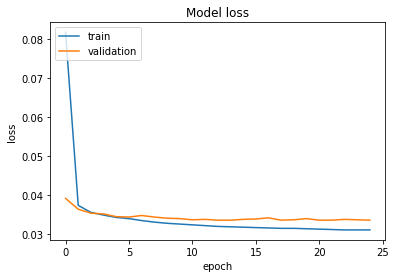

In [27]:
################################################# plot loss and accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
################################## evaluate on test data
model.evaluate(x_test,y_test)

16/16 [==============================] - 2s 94ms/step - loss: 0.0352
0.03524377110004425


### Metrics of predicted enhanced signals

In [14]:
############################################## Make prediction of test data
pred = model.predict(x_test)

In [15]:
############################################### function to obtain metric scores
def get_metrics(y_true,y_pred):
  sdr=[]
  isr=[]
  sar=[]
  nb_pesq=[]
  pesq=[]
  sisdr=[]
  stoi=[]
  mosnet=[]
  srmr=[]
  rate=16000

  my_metrics_relative = speechmetrics.load('relative')
  my_metrics_absolute = speechmetrics.load('absolute')

  for i in range(len(y_true)):


   # print(i)
    try:
      clean = recoverSignalFromSpectrogram(y_true[i])
      enhanced = recoverSignalFromSpectrogram(y_pred[i])
      scipy.io.wavfile.write('clean.wav', rate, clean)
      scipy.io.wavfile.write('enhanced.wav', rate, enhanced)
      rate, ref = wavfile.read("/content/clean.wav")
      rate, deg = wavfile.read("/content/enhanced.wav")

      scores_relative = my_metrics_relative('/content/enhanced.wav', '/content/clean.wav')
      scores_absolute = my_metrics_absolute('/content/enhanced.wav', '/content/clean.wav')

      sdr.append(scores_relative.get('sdr').item())
      isr.append(scores_relative.get('isr').item())
      sar.append(scores_relative.get('sar').item())
      nb_pesq.append(scores_relative.get('nb_pesq').item())
      pesq.append(scores_relative.get('pesq').item())
      sisdr.append(scores_relative.get('sisdr').item())
      stoi.append(scores_relative.get('stoi').item())
      mosnet.append(scores_absolute.get('mosnet').item())
      srmr.append(scores_absolute.get('srmr').item())
  
    except:
      continue

  sdr_score = sum(sdr)/len(sdr)
  isr_score = sum(isr)/len(isr)
  sar_score = sum(sar)/len(sar)
  nb_pesq_score = sum(nb_pesq)/len(nb_pesq)
  pesq_score = sum(pesq)/len(pesq)
  sisdr_score = sum(sisdr)/len(sisdr)
  stoi_score = sum(stoi)/len(stoi)
  mosnet_score = sum(mosnet)/len(mosnet)
  srmr_score = sum(srmr)/len(srmr)

  print('sdr_score:',sdr_score)
  print('isr_score:',isr_score)
  print('sar_score:',sar_score)
  print('nb_pesq_score:',nb_pesq_score)
  print('pesq_score:',pesq_score)
  print('sisdr_score:',sisdr_score)
  print('stoi_score:',stoi_score)
  print('mosnet_score:',mosnet_score)
  print('srmr_score:',srmr_score)

  return 

In [16]:
####################################### obtain prediction metrics
get_metrics(y_test*255,pred*255)

Loaded  speechmetrics.relative.bsseval
Loaded  speechmetrics.relative.nb_pesq
Loaded  speechmetrics.relative.pesq
Loaded  speechmetrics.relative.sisdr
Loaded  speechmetrics.relative.stoi
Physical devices cannot be modified after being initialized
Loaded  speechmetrics.absolute.mosnet
Loaded  speechmetrics.absolute.srmr
/usr/local/lib/python3.7/dist-packages/pystoi/stoi.py:69: RuntimeWarning: Not enough STFT frames to compute intermediate intelligibility measure after removing silent frames. Returning 1e-5. Please check you wav files
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/pypesq/init.py:53: UserWarning: Processing Error! return NaN
  warnings.warn('Processing Error! return NaN')
sdr_score: 0.9047362872014945
isr_score: 5.26288963254372336
sar_score: 3.473493105081486
nb_pesq_score: nan
pesq_score: 1.3985482100078038
sisdr_score: 1.14220905677887
stoi_score: 0.637087637361015
mosnet_score: 2.5102645392644973
srmr_score: 6.080423964459888
